# **从小白视角初识变分自编码器**
**使用VAE和CVAE生成MNIST手写数字**


## 0.扯在前面
复现GAN论文屡次失败使我一蹶不振，终日买醉。今痛定思痛，决定洗心革面，重新做人。由于我的基础薄弱，所以今后会从相对基础、容易复现的东西开始学习。  

***---------------------------------------------------与往日分割----------------------------------------------------***   

生活还要继续，这几天，我开始学习变分自编码器。看到讲解中几乎每行都有“分布”两个字，这让连分布的概念都忘记的我再次产生了放弃的念头。。。  

***------------------------------------------------我来了，又走了--------------------------------------------------***  

“没想到吧，我双回来啦！”  
不再沉沦。  
麻瓜也有麻瓜的好处——学什么都是新的。今天，我就从一个麻瓜的视角，谈谈对变分自编码器的理解。首先从（压缩）自编码器说起，编码器从原始图像提取出具有代表性的信息，解码器再从这些压缩的信息恢复出原来的图像，即试图在学习潜向量的同时重构输入数据。然而，AE的潜空间不是连续的，解码器只能从潜空间中离散的点产生有意义的输出。与AE不同，VAE的潜空间是连续的，并且解码器本身可作为一个生成模型。那么，怎么改造AE使它有生成能力呢？VAE引入一个新的随机变量输入noise，编码器输出两个与随机变量同维的向量，名为mean和std，然后用乘加等操作让noise和mean、std结合起来作为潜变量 z = noise×std + mean。这样，潜向量既与输入图像有关，又有随机性。接着如果和AE一样只用重构损失来训练，会出现问题：输入同一张图像和不同的随机变量，网络倾向于生成一样的图像而不受噪声影响，也就是z中noise的系数会趋向于0，模型退化成AE。VAE为了防止噪声为零，让编码器输出向标准正态分布看齐，即以与标准正态分布的KL散度作为额外损失。   
![](https://ai-studio-static-online.cdn.bcebos.com/444015e4fa2a4623abd52a0f1e7716fa7906c627a6794f2f8f8e01b6df71da5a)  

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import paddle as P 
import paddle.nn as nn 
import paddle.nn.functional as F

place = P.CUDAPlace(0)
P.disable_static(place)
LATENT_DIM = 2
model_path = './output/'

## 1.数据  
使用MNIST数据集

In [2]:
!unzip -qo /home/aistudio/data/data54048/mnist_mat.zip -d /home/aistudio/data

In [3]:
data = h5py.File('/home/aistudio/data/mnist_mat/train.mat')
image = np.array(data['image']).transpose([0,1,3,2]).astype('float32') * 2 - 1
label = np.array(data['label']).reshape([60000,10,1,1]).astype('float32')

## 1.VAE
### 1.1.VAE网络结构  
使用卷积+全连接的结构，全连接习惯性用卷积代替。为了方便后续可视化，潜向量的维度设置为2。

In [4]:
class Encoder(nn.Layer):

    def __init__(self, channel=32, latent=LATENT_DIM):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2D(1,channel,4,2,1)
        self.conv2 = nn.Conv2D(channel,channel*2,4,2,1)
        self.conv_mean = nn.Conv2D(7*7*channel*2,latent,1,1,0)
        self.conv_logvar = nn.Conv2D(7*7*channel*2,latent,1,1,0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = P.reshape(x,[x.shape[0],-1,1,1])
        mean = self.conv_mean(x)
        logvar = self.conv_logvar(x)
        return mean, logvar


class Decoder(nn.Layer):

    def __init__(self, channel=32, latent=LATENT_DIM):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2D(latent,7*7*channel,1,1,0)
        self.conv2 = nn.Conv2DTranspose(channel,channel*2,4,2,1)
        self.conv3 = nn.Conv2DTranspose(channel*2,channel,4,2,1)
        self.conv4 = nn.Conv2D(channel,1,3,1,1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = P.reshape(x,[x.shape[0],-1,7,7])
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.conv4(x)
        x = F.tanh(x)
        return x

### 1.2.辅助函数  
用于训练时显示解码器随机生成的效果

In [5]:
def show_image(is_label, decoder=None):
    if decoder==None:
        decoder = Decoder()
    fig = plt.figure(figsize=(16, 8))
    gs = plt.GridSpec(10, 20)
    gs.update(wspace=0.05, hspace=0.05)
    n = 0
    for i in range(10):
        if is_label == True:
            L = np.zeros([1,10,1,1]).astype('float32')
            L[:,i,:,:] = 1
            L = P.to_tensor(L)  
        for j in range(20):
            ax = plt.subplot(gs[n])
            n += 1
            z = np.random.normal(0.0, 1.0, (1,LATENT_DIM, 1, 1)).astype('float32')
            z = P.to_tensor(z)  
            if is_label == True:
                image = (decoder(z,L).numpy().reshape([28,28]) + 1) / 2
            else:
                image = (decoder(z).numpy().reshape([28,28]) + 1) / 2
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(image, cmap='gray')    
    plt.show()


# show_image(False)

### 1.3.训练
前面说到，编码器要输出名为mean和std的向量，这当然不只是名字，而是真的均值和标准差。由于标准差是非负的，所以实际是取方差的对数logvar。于是潜向量z = noise × $e^{0.5logvar}$ + mean。  
重构损失这里用L2损失，也可用其他。  
KL项为$L_{KL} = {-}\frac{1}{2}\sum_{i=1}^d{(1 + log_{σ_{(i)}^2} - μ_{(i)}^2 - σ_{(i)}^2)}$， 其中d是隐变量z的维度，而$μ_{(i)}$和$σ_{(i)}^2$分别代表一般正态分布的均值向量和方差向量的第i个分量。推导见[变分自编码器（一）：原来是这么一回事。By苏剑林](http://spaces.ac.cn/archives/5253)  


In [6]:
def trainer(x, z, label, encoder, decoder, encoder_optimizer, decoder_optimizer, is_label):
    if is_label == True:
        mean, logvar = encoder(x,label)
    else:
        mean, logvar = encoder(x)
    z = z * P.exp(0.5*logvar) + mean
    if is_label == True:
        y = decoder(z, label)
    else:
        y = decoder(z)
    loss_rec = P.mean(P.sum((x-y)**2,[1,2,3]))
    loss_KL = P.mean(P.sum(-0.5*(1 + logvar - mean**2 - P.exp(logvar)),[1,2,3]))
    loss = loss_rec + loss_KL
    encoder.clear_gradients()
    decoder.clear_gradients()
    loss.backward()
    encoder_optimizer.minimize(loss)
    decoder_optimizer.minimize(loss)


def train(epoch_num, batchsize, load_model, is_label, model_name):
    encoder = Encoder()
    decoder = Decoder()
    encoder_optimizer = P.optimizer.Adam(learning_rate=1e-4, beta1=0.5, parameters=encoder.parameters())
    decoder_optimizer = P.optimizer.Adam(learning_rate=1e-4, beta1=0.5, parameters=decoder.parameters())
    if load_model==True:
        encoder.set_state_dict(P.load(model_path+model_name+'_encoder_'+str(is_label)+'.pdparams'))
        decoder.set_state_dict(P.load(model_path+model_name+'_decoder_'+str(is_label)+'.pdparams'))

    iteration_num = image.shape[0] // batchsize
    for epoch in range(epoch_num):
        sequence = [i for i in range(image.shape[0])]
        np.random.shuffle(sequence)
        image998 = image[sequence,:,:,:]
        label998 = label[sequence,:]
        for iteration in range(iteration_num):       
            image_batch = image998[iteration*batchsize:(iteration+1)*batchsize,:,:,:]
            image_batch = P.to_tensor(image_batch)  
            z = np.random.normal(0.0, 1.0, (batchsize,LATENT_DIM, 1, 1)).astype('float32')
            z = P.to_tensor(z)  
            label_batch = label998[iteration*batchsize:(iteration+1)*batchsize,:,:,:]
            label_batch = P.to_tensor(label_batch)  
            if is_label == True:
                trainer(image_batch, z, label_batch, encoder, decoder, encoder_optimizer, decoder_optimizer, True)
            else:
                trainer(image_batch, z, label_batch, encoder, decoder, encoder_optimizer, decoder_optimizer, False)
                
            if(iteration % 900 == 0):
                print('Epoch: ', epoch, ', Iteration: ', iteration)
                show_image(is_label, decoder)  
                P.save(encoder.state_dict(), model_path+model_name+'_encoder_'+str(is_label)+'.pdparams')
                P.save(decoder.state_dict(), model_path+model_name+'_decoder_'+str(is_label)+'.pdparams')

In [7]:
# train(epoch_num=100, batchsize=64, load_model=False, is_label=False, model_name='A')

### 1.4.结果与讨论

显示随机向量输入解码器的生成效果。

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


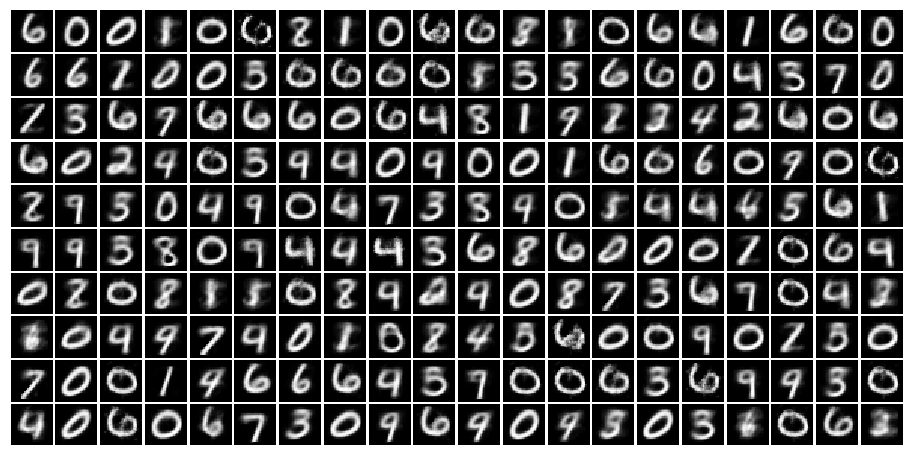

In [8]:
model_name = 'A'
decoder = Decoder()
is_label = False
decoder.set_state_dict(P.load(model_path+model_name+'_decoder_'+str(is_label)+'.pdparams'))
show_image(is_label, decoder) 

只看随机生成，并得不出什么结论。我们取一些样本，观察它们在编码器的输出有何规律。  
可以看到，10种代表不同类别的点，相同类别的聚到了一起，不同类别只有些许重叠。  
顺便，如果编码向量满足标准正态分布，在图中所有的点应该组成单位圆。

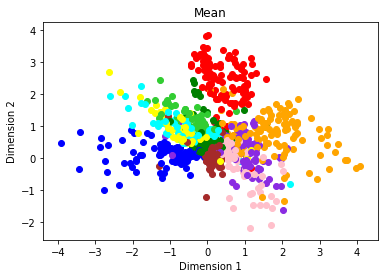

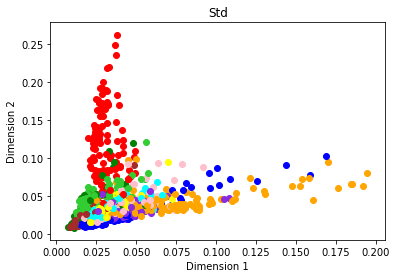

In [9]:
is_label = False
sample = 1000
encoder = Encoder()
encoder.set_state_dict(P.load(model_path+model_name+'_encoder_'+str(is_label)+'.pdparams'))
mean, logvar = encoder(P.to_tensor(image[:sample,:,:,:]))
d1min = np.squeeze(mean[:,0,:,:].min().numpy())
d1max = np.squeeze(mean[:,0,:,:].max().numpy())
d2min = np.squeeze(mean[:,1,:,:].min().numpy())
d2max = np.squeeze(mean[:,1,:,:].max().numpy())
colors = {
        '0':'blue',
        '1':'red',
        '2':'green',
        '3':'yellow',
        '4':'pink',
        '5':'cyan',
        '6':'brown',
        '7':'orange',
        '8':'limegreen',
        '9':'blueviolet'
        }

for i in range(sample):
    x = mean[i,0,:,:]
    y = mean[i,1,:,:]
    plt.scatter(x,y,c=colors[str(np.argmax(label[i,:,:,:]))])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Mean')
plt.show()

for i in range(sample):
    x = P.exp(0.5*logvar)[i,0,:,:]
    y = P.exp(0.5*logvar)[i,1,:,:]
    plt.scatter(x,y,c=colors[str(np.argmax(label[i,:,:,:]))])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Std')
plt.show()

在均值范围内均匀采样一些潜向量，将它们输入解码器观察生成结果，发现生成的图像类别情况对应上面的均值图。

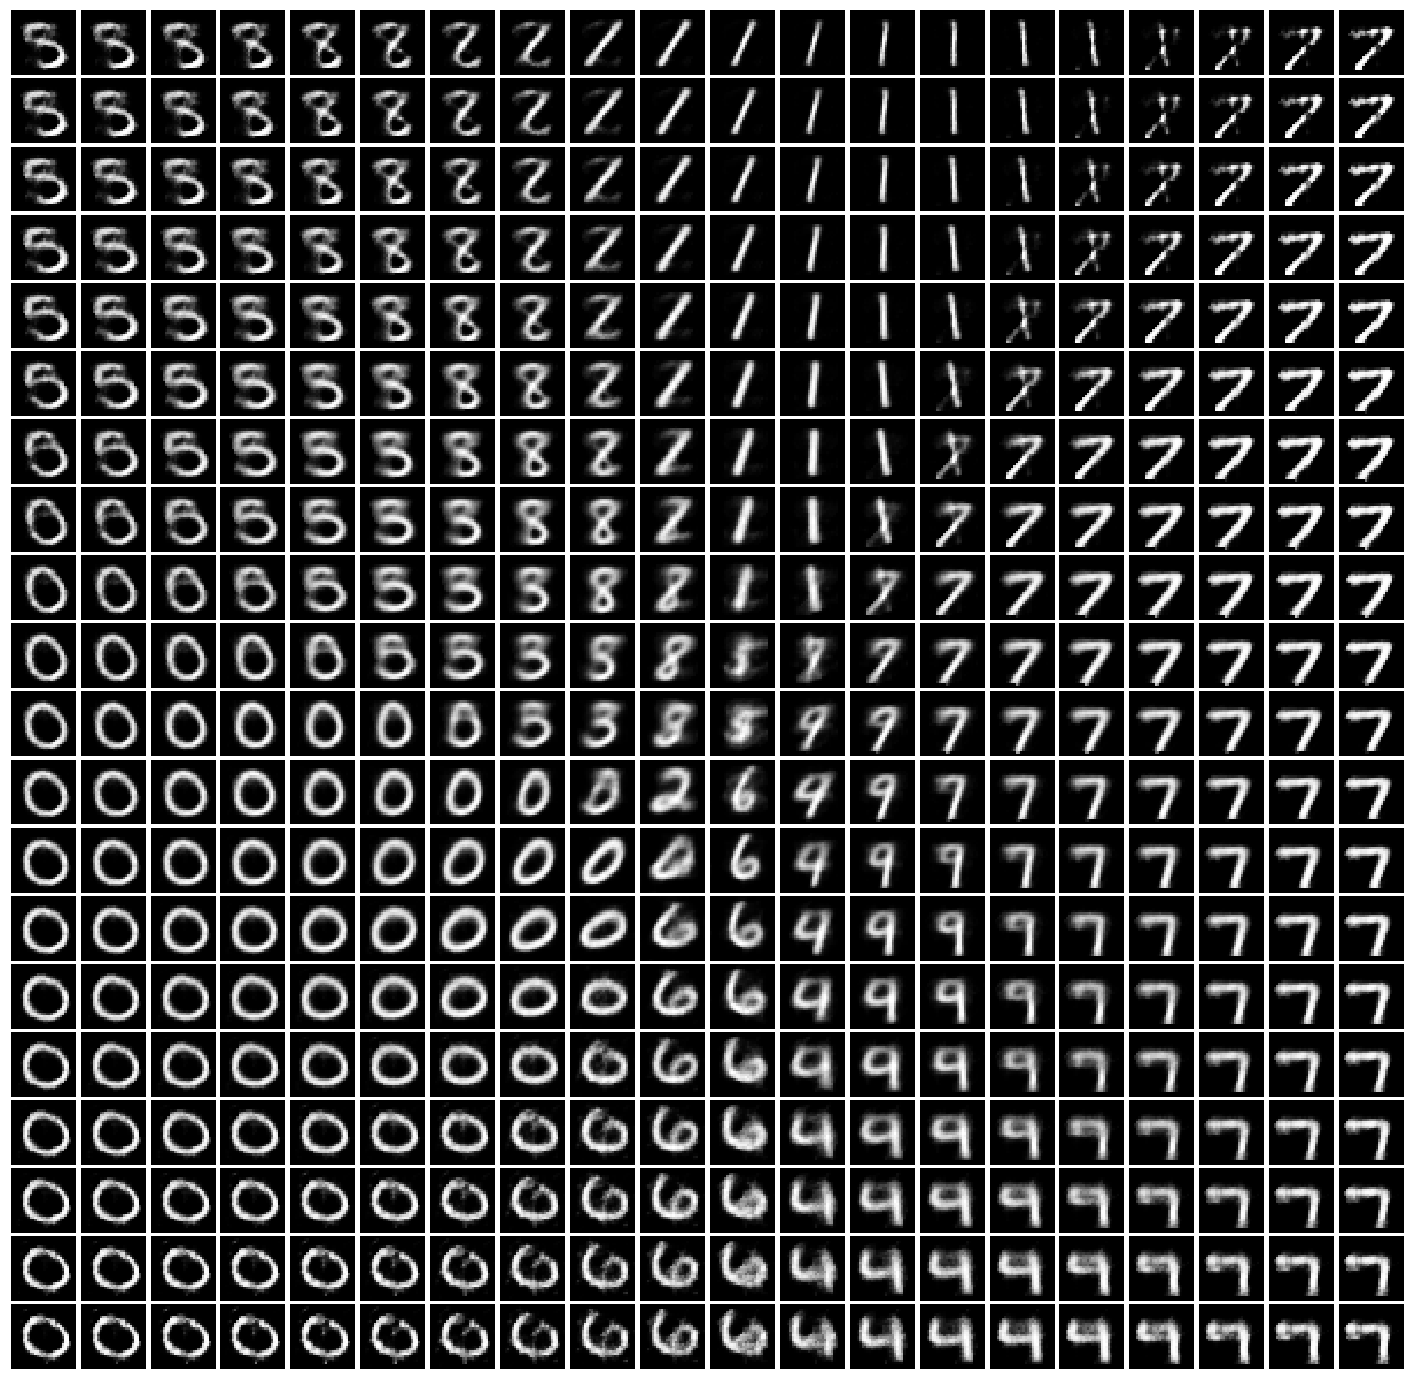

In [10]:
def interpolation2d(x1,x2,y1,y2,x_dim,y_dim):
    x = np.tile(np.linspace(x1,x2,x_dim),y_dim)
    y = np.linspace(y2,y1,y_dim).repeat(x_dim)
    z = np.concatenate((x[:,None],y[:,None]),axis=1)
    return z[:,:,None,None].astype('float32')

row = 20
col = 20
z = interpolation2d(d1min,d1max,d2min,d2max,col,row)
decoder = Decoder()
is_label = False
decoder.set_state_dict(P.load(model_path+model_name+'_decoder_'+str(is_label)+'.pdparams'))
im = (decoder(P.to_tensor(z)).numpy().reshape([z.shape[0],28,28]) + 1) / 2
fig = plt.figure(figsize=(25, 25))
gs = plt.GridSpec(row, col)
gs.update(wspace=0.05, hspace=0.05)
n = 0
for i in range(row): 
    for j in range(col):
        ax = plt.subplot(gs[n])
        plt.imshow(im[n,:,:], cmap='gray')  
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        n += 1
plt.show()


有一个疑问，训练时，随机向量与编码器的输出结合作为潜向量（下图第一行），而训练完成后，可以丢掉编码器，直接用随机向量作为潜向量输入解码器（下图第二行），这两种做法有何异同？  
可以发现，二者没有对应关系（废话。。。）；有时第二行会有比较模糊的结果，是因为均值编码并非标准正态分布，所以在标准正态分布中采样可能会遇到无意义的编码点。

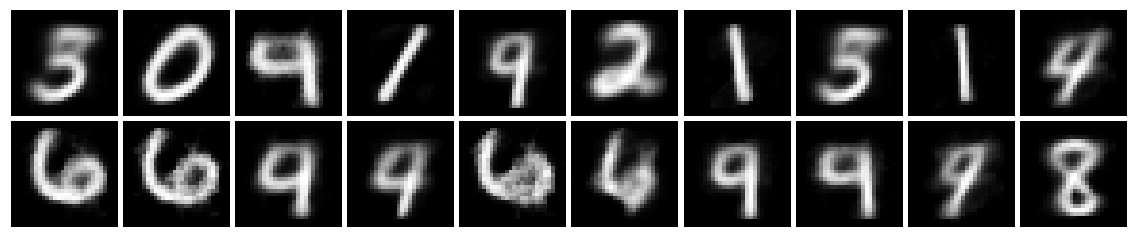

In [11]:
sample = 10
mean, logvar = encoder(P.to_tensor(image[:sample,:,:,:]))
noise = P.to_tensor(np.random.normal(0.0, 1.0, (sample,LATENT_DIM, 1, 1)).astype('float32'))
z1 = noise * P.exp(0.5*logvar) + mean
z2 = noise
im1 = (decoder(z1).numpy().reshape([noise.shape[0],28,28]) + 1) / 2
im2 = (decoder(z2).numpy().reshape([noise.shape[0],28,28]) + 1) / 2

fig = plt.figure(figsize=(20, 4))
gs = plt.GridSpec(2, 10)
gs.update(wspace=0.05, hspace=0.05)
n = 0
for i in range(2): 
    for j in range(10):
        ax = plt.subplot(gs[n])
        if i == 0:
            plt.imshow(im1[n,:,:], cmap='gray')  
        else:
            plt.imshow(im2[n-10,:,:], cmap='gray')  
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        n += 1
plt.show()

我还是不明白，VAE的生成能力到底是怎么来的。试想，如果只用一个样本训练，网络每次迭代输入相同的图像和不同的噪声，却期望重构出同一张图像，这样怎能生成不同的图像？？？  
于是我做了个实验，只用一张“2”图像来训练，并观察此2周围的潜向量生成的图像。  
![](https://ai-studio-static-online.cdn.bcebos.com/fecc6d5323dd426884cc0f1eaa6368b4100c18d0bef146f791c21c6cf88e9de6)  
可以看到，中间的生成结果最清楚，越往外越模糊，但并非“各向同性”。另外，无论清楚与否，2骨子里始终是那一个2。

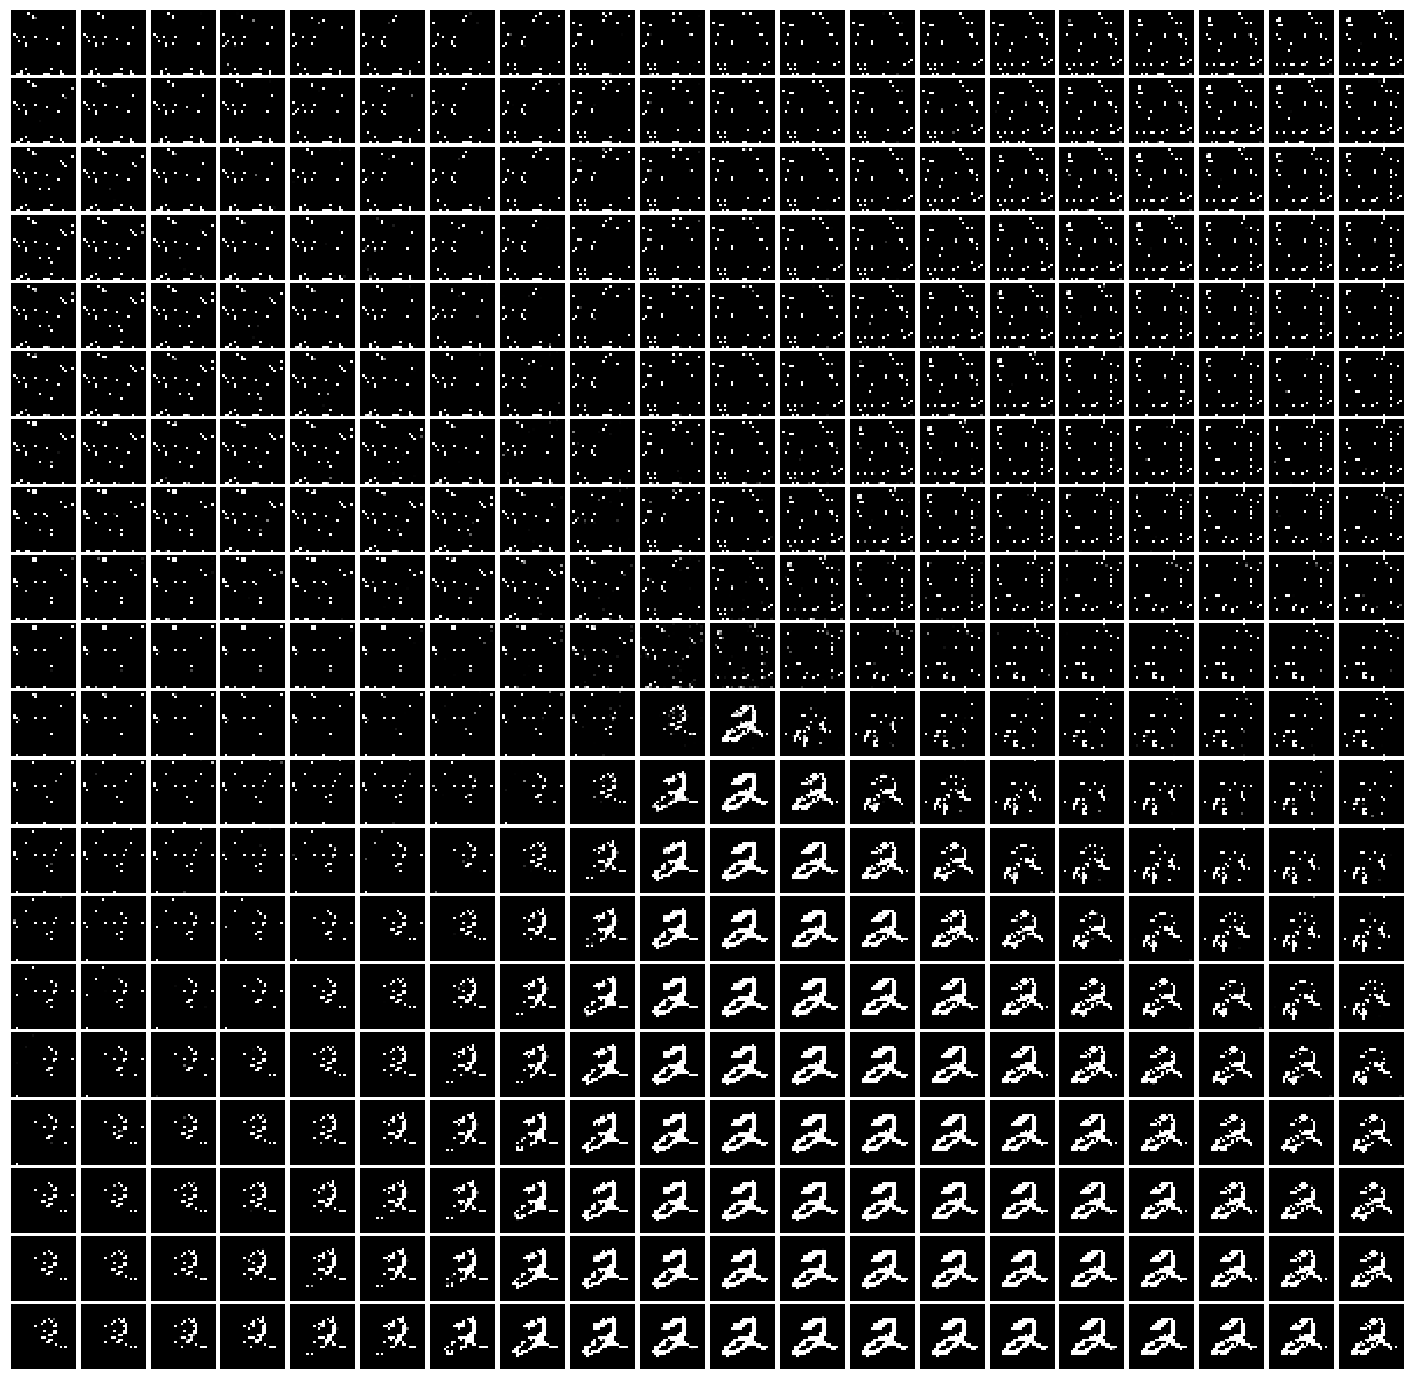

In [12]:
model_name = 'B'
image = np.array(data['image']).transpose([0,1,3,2]).astype('float32') * 2 - 1
image = image[5,:,:,:]
image = image[None,:,:,:]
# train(epoch_num=100, batchsize=1, load_model=False, is_label=False, model_name=model_name)
encoder = Encoder()
encoder.set_state_dict(P.load(model_path+model_name+'_encoder_'+str(is_label)+'.pdparams'))
mean, _ = encoder(P.to_tensor(image))
d1min = np.squeeze(mean[:,0,:,:].numpy()-1000)
d1max = np.squeeze(mean[:,0,:,:].numpy()+1000)
d2min = np.squeeze(mean[:,1,:,:].numpy()-1000)
d2max = np.squeeze(mean[:,1,:,:].numpy()+1000)
row = 20
col = 20
z = interpolation2d(d1min,d1max,d2min,d2max,col,row)
decoder = Decoder()
is_label = False
decoder.set_state_dict(P.load(model_path+model_name+'_decoder_'+str(is_label)+'.pdparams'))
im = (decoder(P.to_tensor(z)).numpy().reshape([z.shape[0],28,28]) + 1) / 2
fig = plt.figure(figsize=(25, 25))
gs = plt.GridSpec(row, col)
gs.update(wspace=0.05, hspace=0.05)
n = 0
for i in range(row): 
    for j in range(col):
        ax = plt.subplot(gs[n])
        plt.imshow(im[n,:,:], cmap='gray')  
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        n += 1
plt.show()

进一步地，如果用以下两个不同的“2”训练，它们之间的潜变量会生成什么呢？  
![](https://ai-studio-static-online.cdn.bcebos.com/8cc2d7f7cca24d2fa77dd5adab6c2e46635e42cdc902469e82d413bc293d0fcf)
![](https://ai-studio-static-online.cdn.bcebos.com/2b0978097ca14726a7fa6603500532da2af2482880e04923adc60026cfa6d0c6)  
两个2平分了中原。  
由此，我有了以下推测：VAE将一个编码点的影响扩大到周围的区域，当有足够多的样本，并对所有编码点作出限制令其密集，那么，在这些编码点影响的区域集合中任意采样，都能生成各种各样有意义的图像了。

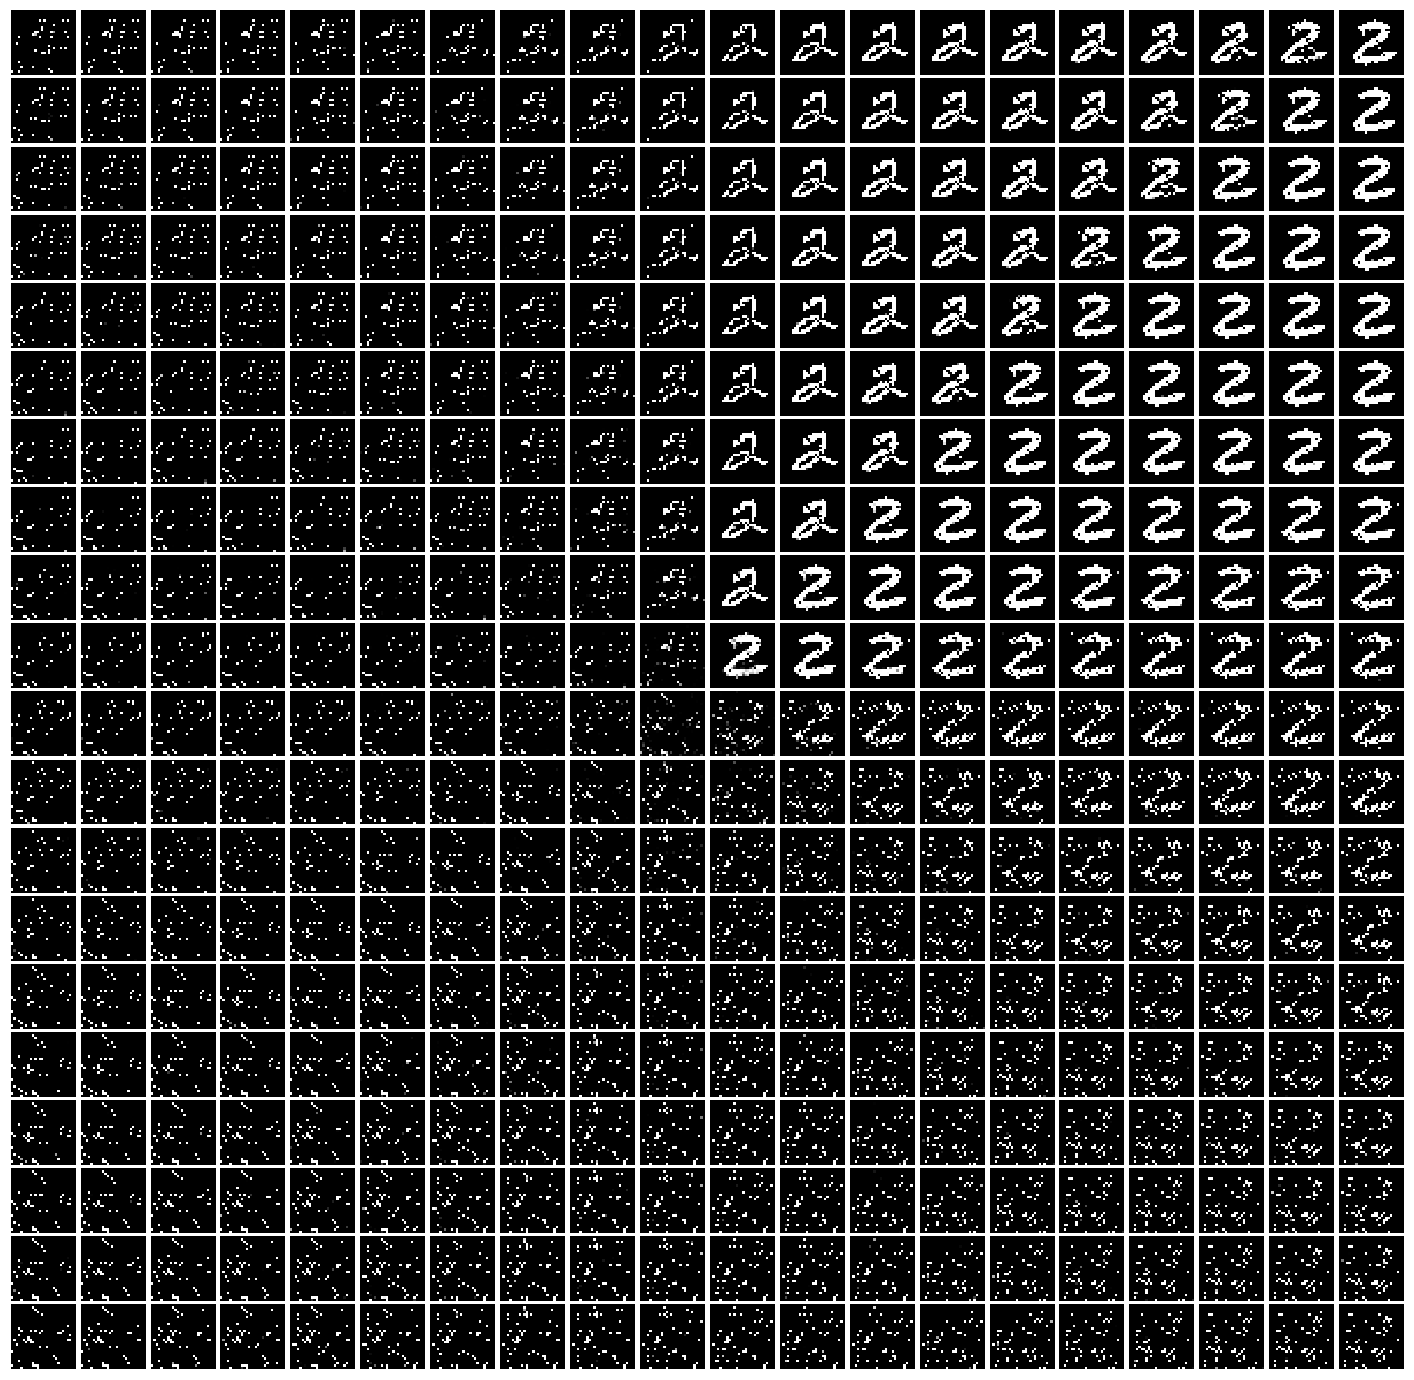

In [13]:
model_name = 'C'
image = np.array(data['image']).transpose([0,1,3,2]).astype('float32') * 2 - 1
image = image[(5,25),:,:,:]
is_label = False
# train(epoch_num=100, batchsize=2, load_model=False, is_label=False, model_name=model_name)
encoder.set_state_dict(P.load(model_path+model_name+'_encoder_'+str(is_label)+'.pdparams'))
mean, _ = encoder(P.to_tensor(image))
d1min = np.squeeze(mean[:,0,:,:].min().numpy()-1000)
d1max = np.squeeze(mean[:,0,:,:].max().numpy()+1000)
d2min = np.squeeze(mean[:,1,:,:].min().numpy()-1000)
d2max = np.squeeze(mean[:,1,:,:].max().numpy()+1000)
row = 20
col = 20
z = interpolation2d(d1min,d1max,d2min,d2max,col,row)
decoder = Decoder()
decoder.set_state_dict(P.load(model_path+model_name+'_decoder_'+str(is_label)+'.pdparams'))
im = (decoder(P.to_tensor(z)).numpy().reshape([z.shape[0],28,28]) + 1) / 2
fig = plt.figure(figsize=(25, 25))
gs = plt.GridSpec(row, col)
gs.update(wspace=0.05, hspace=0.05)
n = 0
for i in range(row): 
    for j in range(col):
        ax = plt.subplot(gs[n])
        plt.imshow(im[n,:,:], cmap='gray')  
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        n += 1
plt.show()

## 2.CVAE  
### 2.1.CVAE网络结构  
像CGAN之于GAN，给VAE加上标签条件，使它变为CVAE。  
添加条件的方法有很多，这里是在编码器和解码器的输入中都拼接上标签。具体，编码器的标签用全连接变换为（图像高×宽）维，reshape后与图像拼接；解码器的标签直接与潜向量拼接。


In [14]:
class Encoder(nn.Layer):

    def __init__(self, channel=32, latent=LATENT_DIM):
        super(Encoder, self).__init__()
        self.conv_label = nn.Conv2D(10,28*28,1,1,0)
        self.conv1 = nn.Conv2D(2,channel,4,2,1)
        self.conv2 = nn.Conv2D(channel,channel*2,4,2,1)
        self.conv_mean = nn.Conv2D(7*7*channel*2,latent,1,1,0)
        self.conv_logvar = nn.Conv2D(7*7*channel*2,latent,1,1,0)
    
    def forward(self, x, label):
        label = self.conv_label(label)
        label = P.reshape(label, [label.shape[0],-1,28,28])
        x = P.concat([x,label],1)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = P.reshape(x,[x.shape[0],-1,1,1])
        mean = self.conv_mean(x)
        logvar = self.conv_logvar(x)
        return mean, logvar


class Decoder(nn.Layer):

    def __init__(self, channel=32, latent=LATENT_DIM):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2D(latent+10,7*7*channel,1,1,0)
        self.conv2 = nn.Conv2DTranspose(channel,channel*2,4,2,1)
        self.conv3 = nn.Conv2DTranspose(channel*2,channel,4,2,1)
        self.conv4 = nn.Conv2D(channel,1,3,1,1)
    
    def forward(self, x, label):
        x = P.concat([x,label],1)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = P.reshape(x,[x.shape[0],-1,7,7])
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.conv4(x)
        x = F.tanh(x)
        return x


### 2.2.训练

In [15]:
image = np.array(data['image']).transpose([0,1,3,2]).astype('float32') * 2 - 1
# train(epoch_num=100, batchsize=64, load_model=False, is_label=True, model_name='D')

### 2.3.结果与讨论

首先是根据不同标签随机生成。

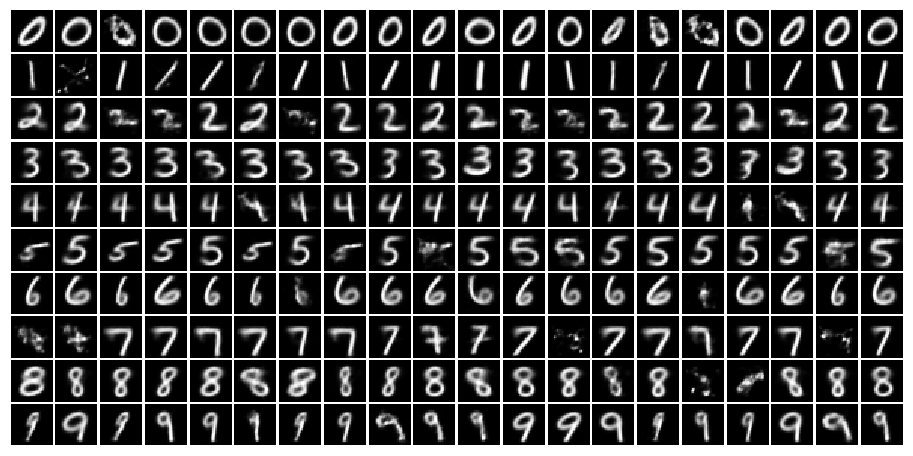

In [16]:
model_name = 'D'
decoder = Decoder()
is_label = True
decoder.set_state_dict(P.load(model_path+model_name+'_decoder_'+str(is_label)+'.pdparams'))
show_image(is_label, decoder) 

接着观察CVAE的潜空间。与VAE不同，不同类别的点并没有泾渭分明，而是散布在整个图中。

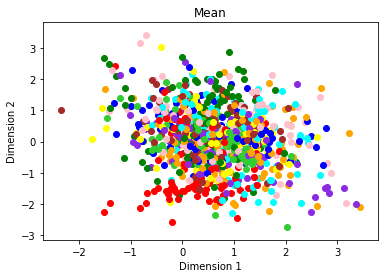

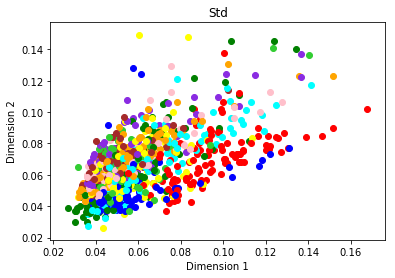

In [17]:
is_label = True
sample = 1000
encoder = Encoder()
encoder.set_state_dict(P.load(model_path+model_name+'_encoder_'+str(is_label)+'.pdparams'))
mean, logvar = encoder(P.to_tensor(image[:sample,:,:,:]),P.to_tensor(label[:sample,:,:,:]))
d1min = np.squeeze(mean[:,0,:,:].min().numpy())
d1max = np.squeeze(mean[:,0,:,:].max().numpy())
d2min = np.squeeze(mean[:,1,:,:].min().numpy())
d2max = np.squeeze(mean[:,1,:,:].max().numpy())

for i in range(sample):
    x = mean[i,0,:,:]
    y = mean[i,1,:,:]
    plt.scatter(x,y,c=colors[str(np.argmax(label[i,:,:,:]))])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Mean')
plt.show()

for i in range(sample):
    x = P.exp(0.5*logvar)[i,0,:,:]
    y = P.exp(0.5*logvar)[i,1,:,:]
    plt.scatter(x,y,c=colors[str(np.argmax(label[i,:,:,:]))])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Std')
plt.show()

均匀采样潜空间，根据不同的标签生成图像。可以观察到，不同类别的数字有相似的变化规律。

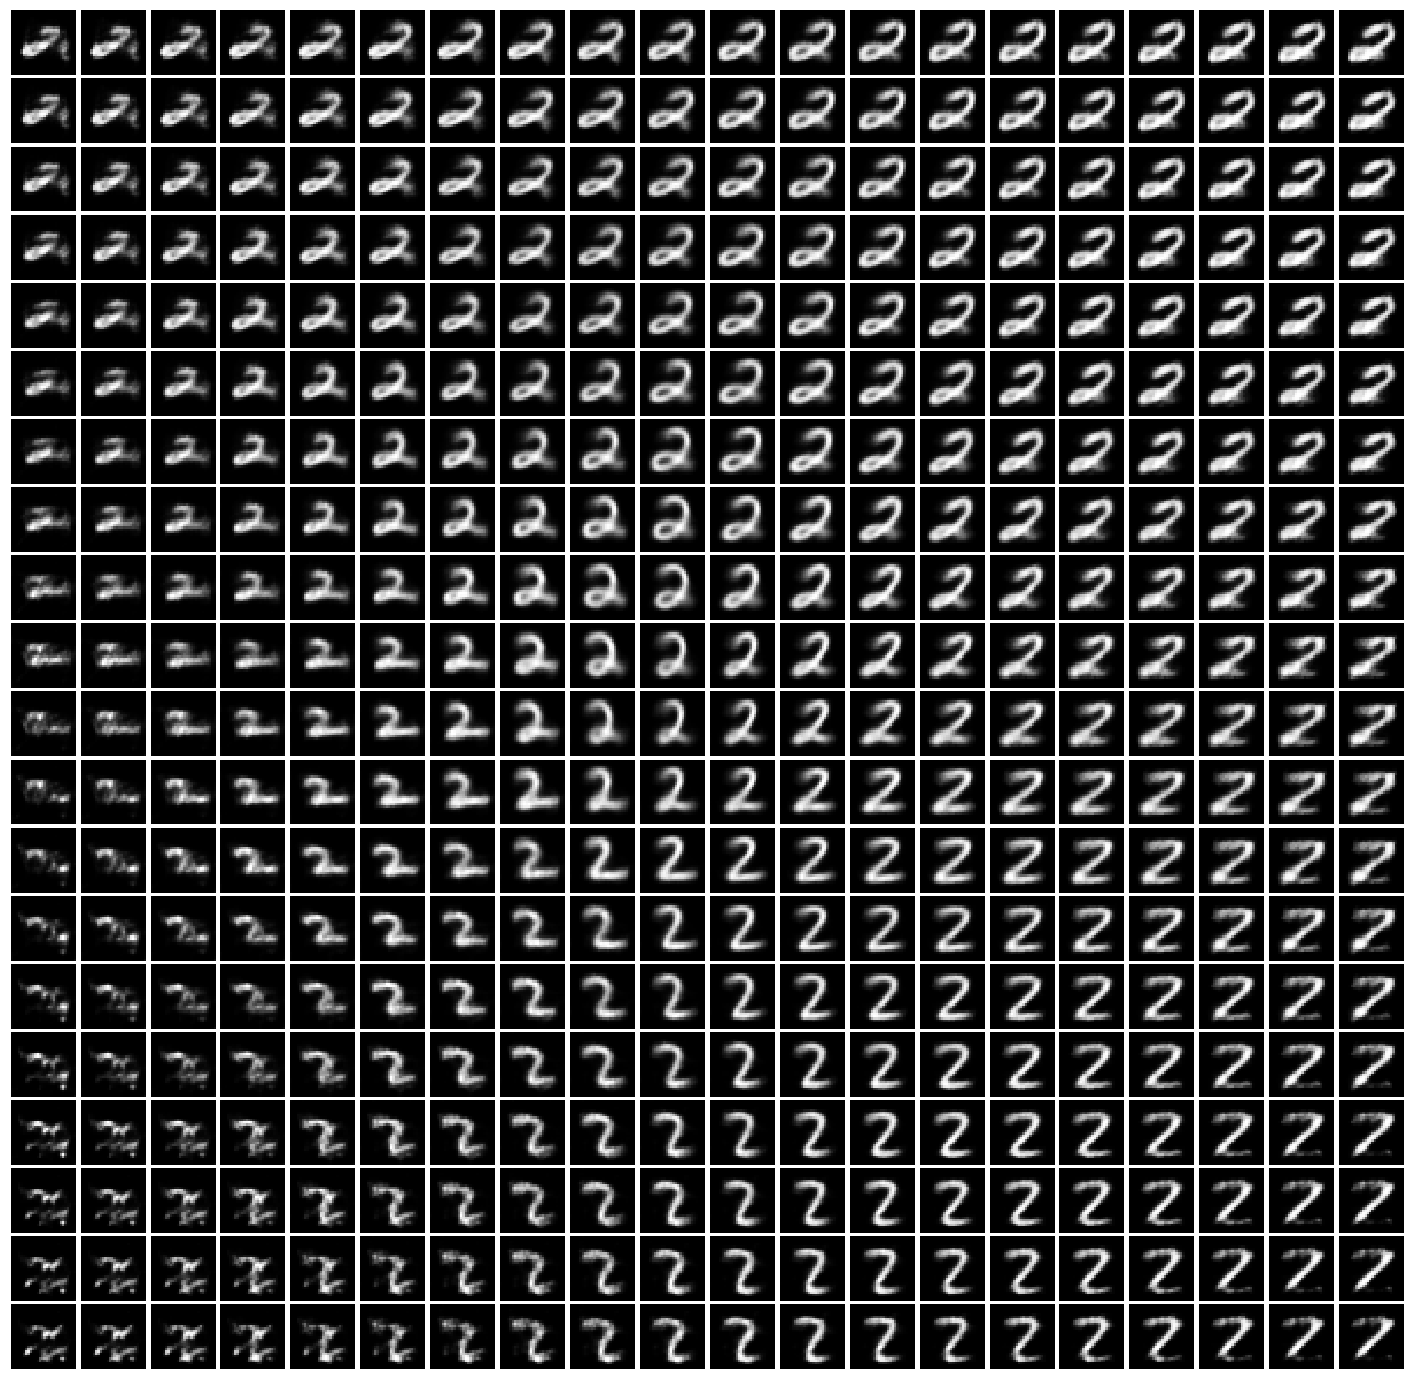

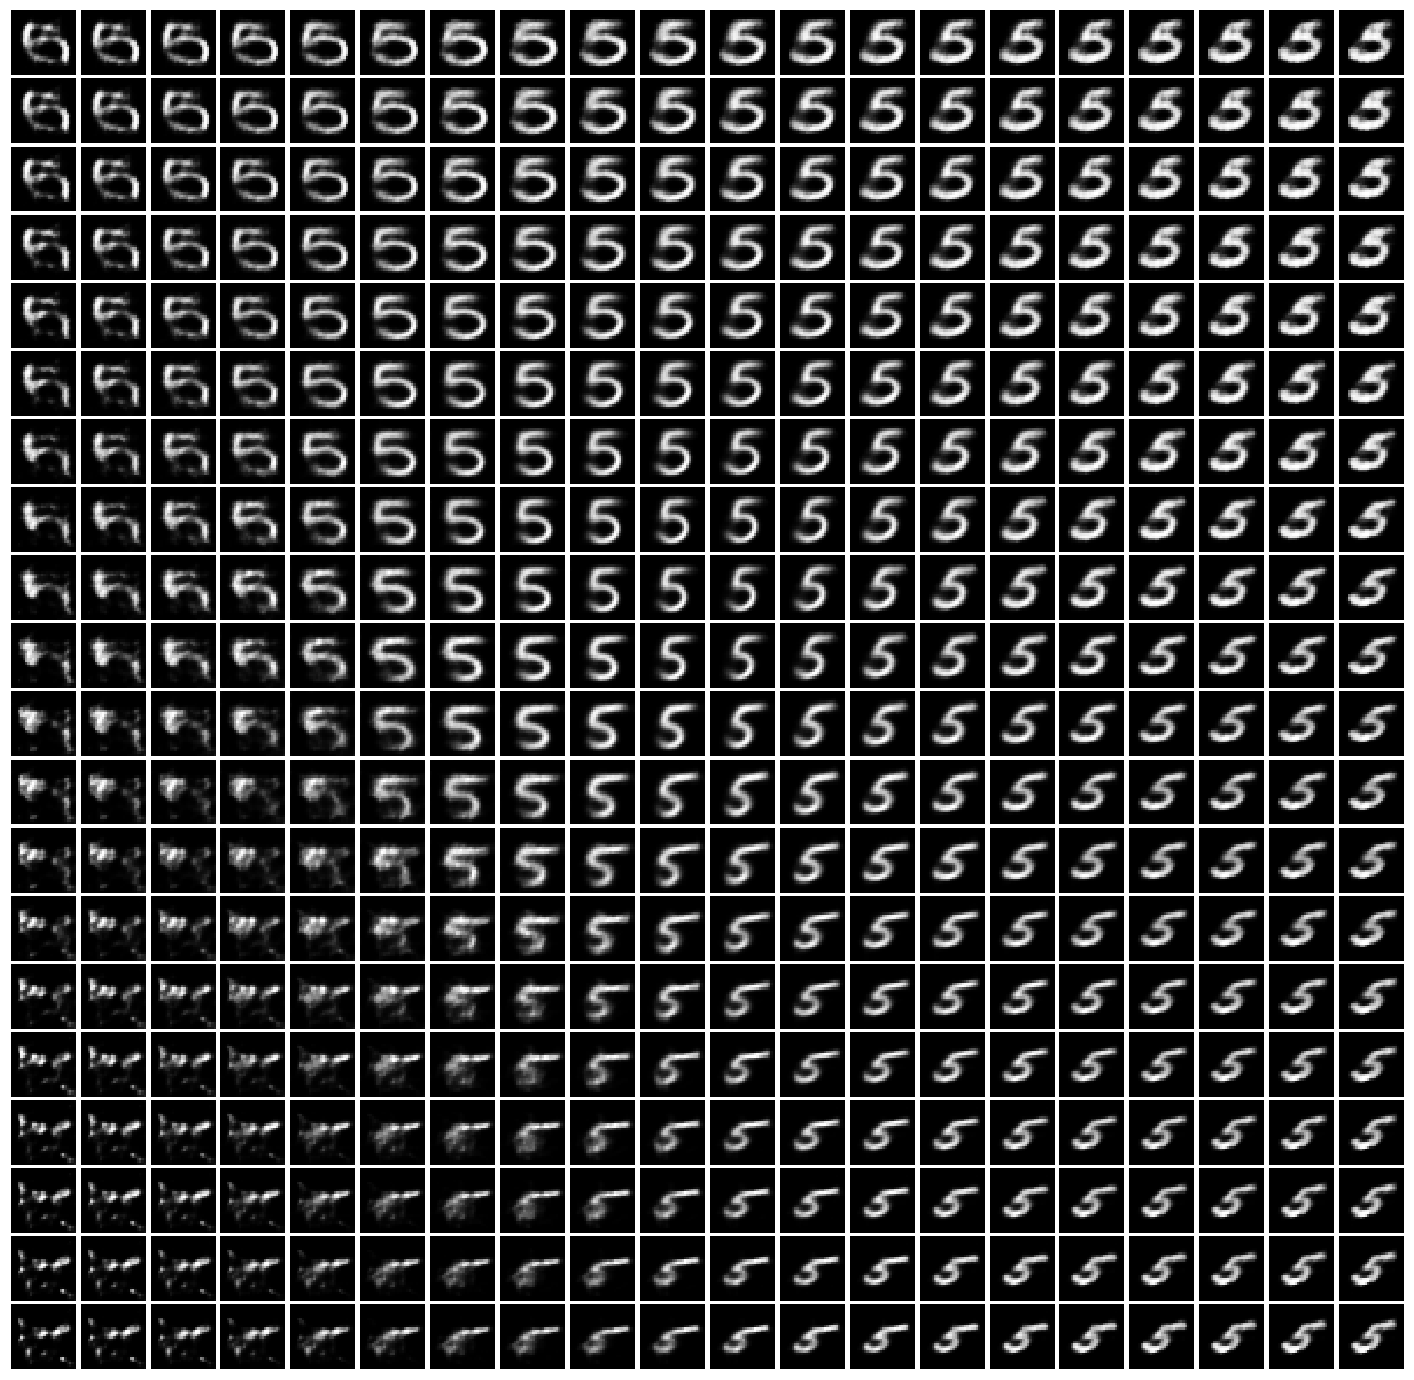

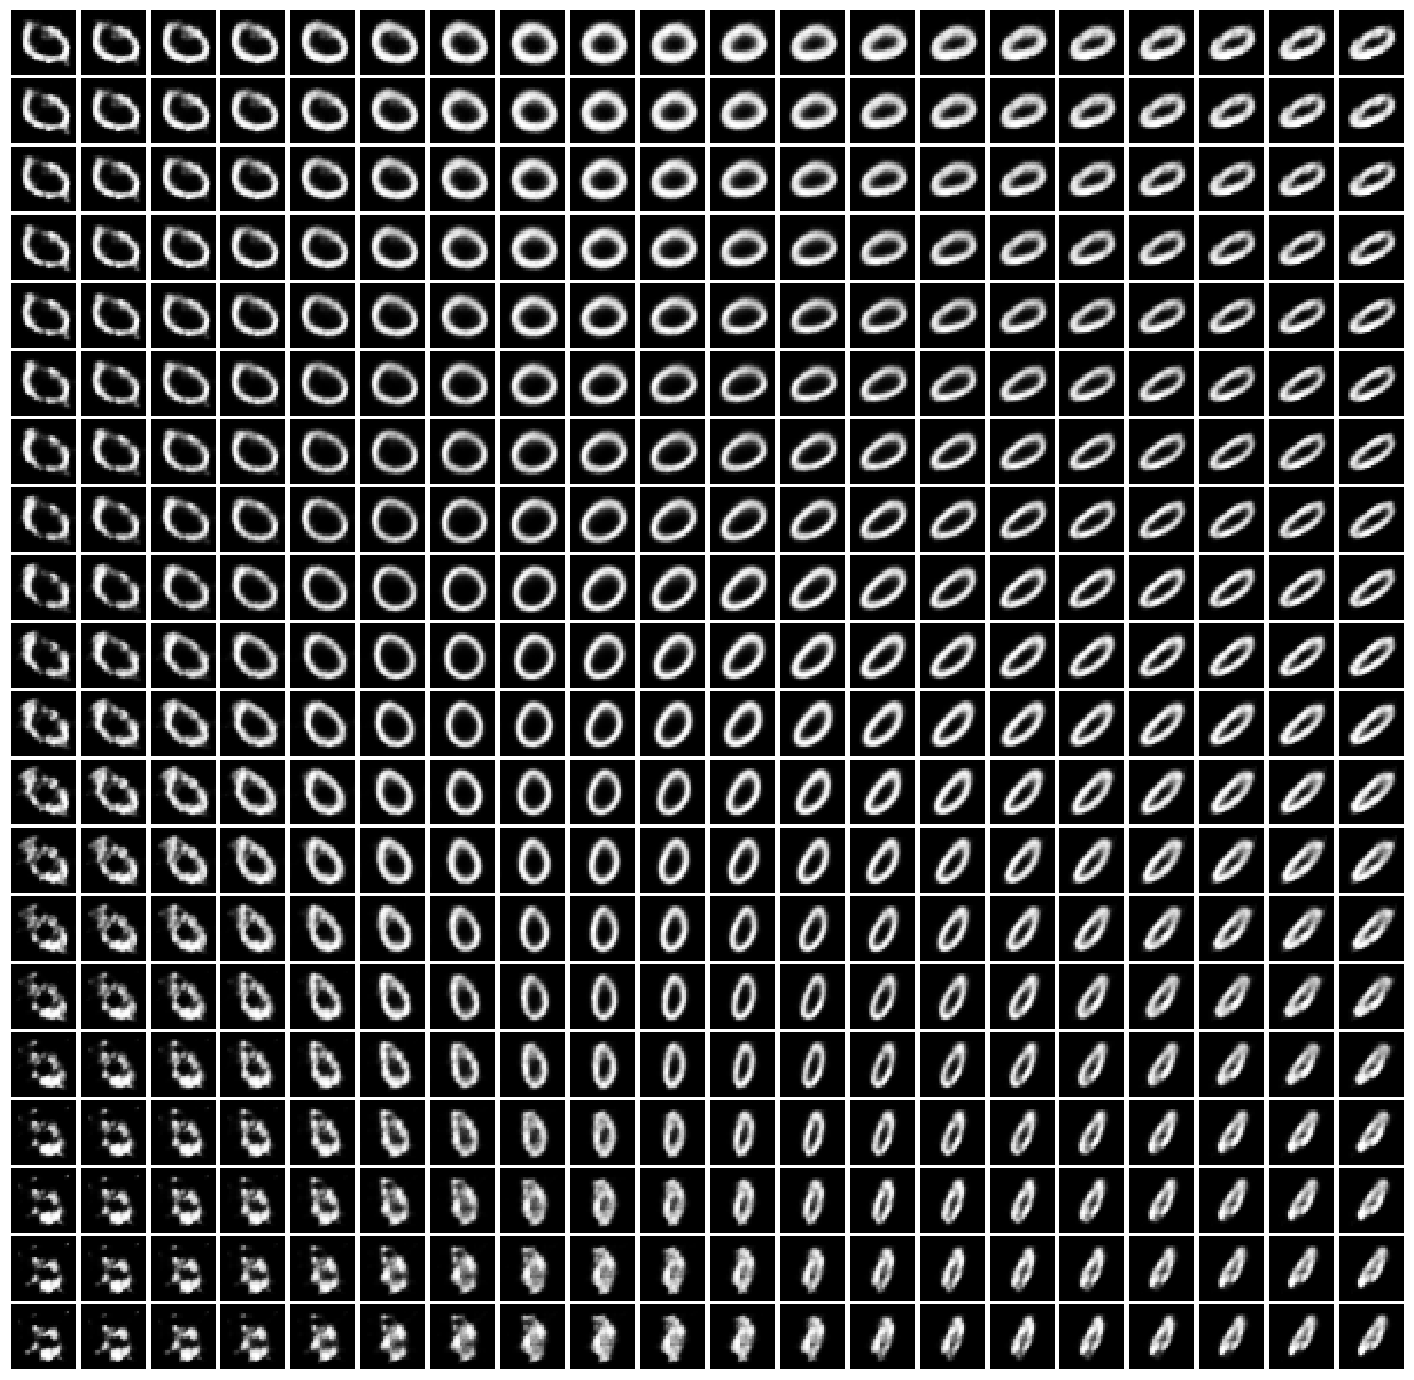

In [18]:
row = 20
col = 20
z = interpolation2d(d1min,d1max,d2min,d2max,col,row)
decoder = Decoder()
is_label = True
decoder.set_state_dict(P.load(model_path+model_name+'_decoder_'+str(is_label)+'.pdparams'))
# im = (decoder(P.to_tensor(z)).numpy().reshape([z.shape[0],28,28]) + 1) / 2

def show250(label):
    im = (decoder(P.to_tensor(z),P.to_tensor(label)).numpy().reshape([z.shape[0],28,28]) + 1) / 2
    fig = plt.figure(figsize=(25, 25))
    gs = plt.GridSpec(row, col)
    gs.update(wspace=0.05, hspace=0.05)
    n = 0
    for i in range(row): 
        for j in range(col):
            ax = plt.subplot(gs[n])
            plt.imshow(im[n,:,:], cmap='gray')  
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            n += 1
    plt.show()

eye10 = np.eye(10)
label = np.ones([z.shape[0],10,1,1]) * eye10[2][None,:,None,None]
show250(label.astype('float32'))
label = np.ones([z.shape[0],10,1,1]) * eye10[5][None,:,None,None]
show250(label.astype('float32'))
label = np.ones([z.shape[0],10,1,1]) * eye10[0][None,:,None,None]
show250(label.astype('float32'))

## 3.总结  
从麻瓜视角初步入门了VAE，但想真正深刻理解它，数学是逃避不掉的。。。  
emm看书去。

# 作者  

In [19]:
class 王伟:
    
    def __init__(self, 有深度学习相关方向的博导收):
        if 有深度学习相关方向的博导收 == True:
            self.竟是这结局 = '教练。我。。。我想daaa读博！'
        else:
            self.竟是这结局 = '六月毕业，肥家种地。'


种地的王伟 = 王伟(998)
print('只能被毁灭————', 种地的王伟.竟是这结局)

读博的王伟 = 王伟(1)
print('绝不会屈服————', 读博的王伟.竟是这结局)


只能被毁灭———— 六月毕业，肥家种地。
绝不会屈服———— 教练。我。。。我想daaa读博！
